# Text mining insights from Covid-19 Research Papers

The aim of this Notebook is to extract meaningful insights from Covid-19 research papers available from [Allen Institude](https://www.semanticscholar.org/cord19/download). 
Following are few questions that I will try to address in this Notebook:

- **Is it possible to identify relevant research papers that are most relevant and filter out the noise?**
- **Can we ascertain demand for certain drugs by analyzing these research papers?**
- **Is it possible to identify efficacy of certain drugs i.e. can we identify which drugs have been most effective in treating patients?**


## Import Libraries

In [ ]:
# import libraries
import os
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import re
import pickle
import json
from itertools import *


from gensim.corpora import Dictionary
from gensim.models.ldamulticore import LdaMulticore
from gensim.matutils import softcossim

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from collections import Counter
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
import nltk
nltk.download(['punkt', 'wordnet', 'averaged_perceptron_tagger', 'stopwords'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

## Load Data

We will load two data sets:
1.   Clean research paper data extracted in a separate [Notebook](https://github.com/nikyan/Covid-19_Research/blob/master/Covid_19_Research_Paper_ETL.ipynb).
2.   NDC drug list from [NDC website](https://www.fda.gov/drugs/drug-approvals-and-databases/national-drug-code-directory).



In [ ]:
# function to load data from sqlite database
def load_data():
    engine = create_engine('sqlite:///../content/drive/My Drive/ML data/ai2_research_data.db')
    df = pd.read_sql_table('research_data', engine)
    return df

    #/content/drive/My Drive/ML data/ai2_research_data.db

In [ ]:
# load data to a dataframe
df = load_data()
# check data
print(df.shape)
df.head(2)

(4776, 3)


,paper_id,title,text
0,0036b28fddf7e93da0970303672934ea2f9944e7,The fecal microbiota and unconjugated fecal bi...,human type 1 DM. The aim of this study was to ...
1,004f0f69464edd5466a947da86d38cea9fe7e4fe,Human Pregnancy Specific Beta-1-Glycoprotein 1...,Pregnancy specific beta-1-glycoproteins (PSGs)...


In [ ]:
# # get NDC drug data
# # https://www.fda.gov/drugs/drug-approvals-and-databases/national-drug-code-directory

file1 = '../content/drive/My Drive/ML data/NDC Drug Data/package.txt'
file2 = '../content/drive/My Drive/ML data/NDC Drug Data/product.txt'

ndc_package = pd.read_table(file1)
ndc_product = pd.read_table(file2, encoding = 'unicode_escape')

In [ ]:
#df3 = ndc_product[(ndc_product.NONPROPRIETARYNAME.str.find('chloroquine') !=-1) & (ndc_product.NONPROPRIETARYNAME.notna())]

In [ ]:
ndc_product.head(5)

,PRODUCTID,PRODUCTNDC,PRODUCTTYPENAME,PROPRIETARYNAME,PROPRIETARYNAMESUFFIX,NONPROPRIETARYNAME,DOSAGEFORMNAME,ROUTENAME,STARTMARKETINGDATE,ENDMARKETINGDATE,MARKETINGCATEGORYNAME,APPLICATIONNUMBER,LABELERNAME,SUBSTANCENAME,ACTIVE_NUMERATOR_STRENGTH,ACTIVE_INGRED_UNIT,PHARM_CLASSES,DEASCHEDULE,NDC_EXCLUDE_FLAG,LISTING_RECORD_CERTIFIED_THROUGH
0,0002-0800_94c48759-29bb-402d-afff-9a713be11f0e,0002-0800,HUMAN OTC DRUG,Sterile Diluent,NaN,diluent,"INJECTION, SOLUTION",SUBCUTANEOUS,19870710,NaN,NDA,NDA018781,Eli Lilly and Company,WATER,1,mL/mL,NaN,NaN,N,20201231.0
1,0002-1200_35551a38-7a8d-43b8-8abd-f6cb7549e932,0002-1200,HUMAN PRESCRIPTION DRUG,Amyvid,NaN,Florbetapir F 18,"INJECTION, SOLUTION",INTRAVENOUS,20120601,NaN,NDA,NDA202008,Eli Lilly and Company,FLORBETAPIR F-18,51,mCi/mL,"Radioactive Diagnostic Agent [EPC],Positron Em...",NaN,N,20211231.0
2,0002-1433_7aa69ac3-eb3d-4525-9ea0-9eea11babb5f,0002-1433,HUMAN PRESCRIPTION DRUG,Trulicity,NaN,Dulaglutide,"INJECTION, SOLUTION",SUBCUTANEOUS,20140918,NaN,BLA,BLA125469,Eli Lilly and Company,DULAGLUTIDE,.75,mg/.5mL,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",NaN,N,20211231.0
3,0002-1434_7aa69ac3-eb3d-4525-9ea0-9eea11babb5f,0002-1434,HUMAN PRESCRIPTION DRUG,Trulicity,NaN,Dulaglutide,"INJECTION, SOLUTION",SUBCUTANEOUS,20140918,NaN,BLA,BLA125469,Eli Lilly and Company,DULAGLUTIDE,1.5,mg/.5mL,"GLP-1 Receptor Agonist [EPC],Glucagon-Like Pep...",NaN,N,20211231.0
4,0002-1436_dd7f66eb-66e1-4ad0-a593-417dbf2c74e2,0002-1436,HUMAN PRESCRIPTION DRUG,EMGALITY,NaN,galcanezumab,"INJECTION, SOLUTION",SUBCUTANEOUS,20180927,NaN,BLA,BLA761063,Eli Lilly and Company,GALCANEZUMAB,120,mg/mL,NaN,NaN,N,20201231.0


I load two data sets from NDC:
- NDC Package
- NDC Product

I find NDC Product data useful especially the 'NONPROPRIETARYNAME' field.


---



## Clean Research Paper data

In this step, I will perform number of steps to clean the data.

In [ ]:
# remove punctuation
def get_good_tokens(sentence):
    replaced_punctation = list(map(lambda token: re.sub('[^0-9A-Za-z!?]+', '', token), sentence))
    removed_punctation = list(filter(lambda token: token, replaced_punctation))
    return removed_punctation

# get tokenized text
def lda_get_good_tokens(df):
    df['original_text'] = df['text']
    df['text'] = df.text.str.lower()
    df['tokenized_text'] = list(map(nltk.word_tokenize, df.text))
    df['tokenized_text'] = list(map(get_good_tokens, df.tokenized_text))

lda_get_good_tokens(df)

In [ ]:
# remove stop words to clean up tokenized text
def remove_stopwords(df):
    """ Removes stopwords based on a known set of stopwords
    available in the nltk package.
    """
    # set of stopwords from nltk
    stopwords = nltk.corpus.stopwords.words('english')

    df['stopwords_removed'] = list(map(lambda doc:
                                       [word for word in doc if word not in stopwords],
                                       df['tokenized_text']))

remove_stopwords(df)

In [ ]:
# creat a list of possible covid related terms
# I will use this to filter out articles that have absolutely no mention of the covid-19 or related virus.
covidwords = ['covid', 'covid-19', 'cov', 'hcov']

# identify papers with mention of corona virus or simiar virus such as sars, h1n1, mers
def identify_corona_papers(df):
    """ Identifies papers that have mention of corona virus based on a known set of words.
    """
  
    df['contains_corona'] = list(map(lambda doc:
                                       [word for word in doc if word in covidwords],
                                       df['tokenized_text']))
    df['contains_corona'] = list(map(lambda doc: None if len(doc) == 0 else doc, df['contains_corona']))

identify_corona_papers(df)
# how many articles that don't have any mention of corona virus
print("Articles that don't have any mention of corona virus: {}".format(df.contains_corona.isnull().sum()))
# filter out articles that have no mention of corona virus
df = df[~df.contains_corona.isnull()]
print("Articles left: {}".format(df.shape[0]))

Articles that don't have any mention of corona virus: 4444
Articles left: 332


In [ ]:
# Lets look at the titles and see if there are duplicates
# remove duplicates by title
df.drop_duplicates(subset='title', keep='first', inplace=True)
df.shape[0]

228

**Filtering out non Covid related research paper leaves us with only 332 research papers to work with. This is an important step in reducing noise and focusing on relevant research papers for analysis. Finally, by removing duplicates we are only left with 228 research papers.**

---




### Question 1
Is it possible to identify relevant research papers that are most relevant and filter out the noise?

**Analysis steps:** Achieved through a simple way by filtering out research paper by certain keywords.

**Outcome:** 
Research paper corpus: 4776
Research paper with no mention of keywords: 4444
Relevant research papers: 332

## NDC Drug data clean up

- create a dictionary of drug names from the NDC drug database

In [ ]:
ndc_prod_lt = ndc_product['NONPROPRIETARYNAME'].str.lower()
ndc_prod_lt = list(ndc_prod_lt.unique())

In [ ]:
# drug list clean up
# split words with comma and create a unique list of drug names.
# clean up the list for any special characters, trailing spaces or orphan 'and'
ndc_prod_list = []
for words in ndc_prod_lt:
  words = re.split(',', str(words))
  ndc_prod_list.extend(words)

#ndc_prod_list = [x.strip('and') for x in ndc_prod_list]
ndc_prod_list = [re.sub('[^0-9A-Za-z!?]+', ' ', x) for x in ndc_prod_list]
ndc_prod_list = [re.sub('and ','',x) for x in ndc_prod_list]
ndc_prod_list = [x.strip(' ') for x in ndc_prod_list]
len(ndc_prod_list)

53049

In [ ]:
# remove duplicates
ndc_prod_list = list(dict.fromkeys(ndc_prod_list))
len(ndc_prod_list)

12666

In [ ]:
# remove words less than 2 in length
ndc_prod_list = [s for s in ndc_prod_list if len(s) > 2]

In [ ]:
# add few drug names that are missing from the list
ndc_prod_list.append('remdesivir')
ndc_prod_list.append('chloroquine')
ndc_prod_list.append('umifenovir')
ndc_prod_list.append('favipiravir')
ndc_prod_list.append('lopinavir')
ndc_prod_list.append('ritonavir')

In [ ]:
# remove unwanted words from drug list
unwanted_words = ['18 vaccine','live','oral','inactivated','sterile water','insulin human','human insulin',
                  'water injection','insulin aspart injection','common','short','mixed','solution','none','gel']

ndc_prod_list = [x for x in ndc_prod_list if x not in unwanted_words]
len(ndc_prod_list)

12624

In [ ]:
# test the list for any drug name
res = [k for k in ndc_prod_list if 'remdesivir' in k]
res

['remdesivir']

## Research Data - Add matching Drug Data

In [ ]:
# find research papers with mention of drug names from the NDC product list.
%%time
df['match_words'] = list(map(lambda doc: [word for word in doc if word in ndc_prod_list], df.tokenized_text))

CPU times: user 2min 59s, sys: 13.9 ms, total: 2min 59s
Wall time: 2min 59s


In [ ]:
# count frequency of occurence
df['match_words_freq'] = list(map(lambda doc: Counter(doc), df.match_words))

In [ ]:
# save a pickle file for later use.
# filename = "../content/drive/My Drive/ML data/research_drug_data.p"
# pickle.dump(df,open(filename, "wb"))

In [ ]:
# Load pickle file with pre-processed data
# filename = "../content/drive/My Drive/ML data/research_drug_data.p"
# df = pickle.load(open(filename, "rb" ))

In [ ]:
# review the dataframe with matched words
df.head(2)

,paper_id,title,text,original_text,tokenized_text,contains_corona,stopwords_removed,match_words,match_words_freq
2,005c43980edf3fcc2a4d12ee7ad630ddb651ce6e,Development of a smartphone-based rapid dual f...,avian influenza (ai) viruses are distinct from...,Avian influenza (AI) viruses are distinct from...,"[avian, influenza, ai, viruses, are, distinct,...","[cov, cov, cov]","[avian, influenza, ai, viruses, distinct, huma...","[gold, water, chicken, conjugated, mouse, coat...","{'gold': 1, 'water': 2, 'chicken': 2, 'conjuga..."
32,0346cb9d0f5b07fe50d9a3cc0378a53f1a87708c,Statins May Decrease the Fatality Rate of Midd...,t he recent paper by totura and colleagues (1)...,T he recent paper by Totura and colleagues (1)...,"[t, he, recent, paper, by, totura, and, collea...",[cov],"[recent, paper, totura, colleagues, 1, reveale...","[ribavirin, lead, celecoxib, mesalamine, cyclo...","{'ribavirin': 1, 'lead': 1, 'celecoxib': 1, 'm..."


## Analyze Drug Data
- In this section, I perfrom analysis on the data (research paper, drug data) to generate insights.

In [ ]:
#view top word frequencies from the matched drug data
matched_only_dict = Counter(np.concatenate(df.match_words.values))
matched_only_df = pd.DataFrame.from_dict(matched_only_dict, orient='index')
matched_only_df.rename(columns={0: 'count'}, inplace=True)
matched_only_df.sort_values('count', ascending=False, inplace=True)
#matched_only_df.sort_values('count', ascending=True, inplace=True)

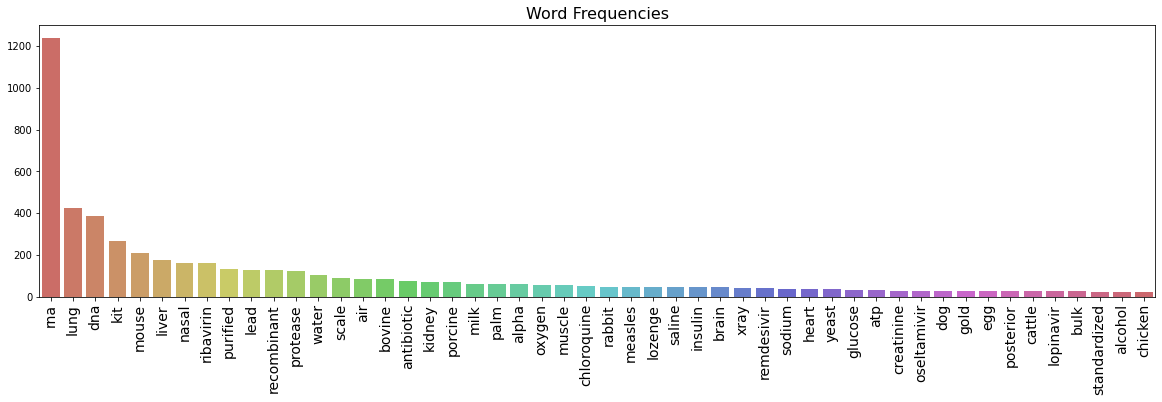

In [ ]:
# function to plot word frequency 
def word_frequency_barplot(df, nr_top_words=50):
    """ df should have a column named count.
        returns a plot of word frequency.
    """
    fig, ax = plt.subplots(1,1,figsize=(20,5))

    sns.barplot(list(range(nr_top_words)), df['count'].values[:nr_top_words], palette='hls', ax=ax)

    ax.set_xticks(list(range(nr_top_words)))
    ax.set_xticklabels(df.index[:nr_top_words], fontsize=14, rotation=90)
    return ax
    
ax = word_frequency_barplot(matched_only_df)
ax.set_title("Word Frequencies", fontsize=16);

The results are quite interesting and as expected as well. If you scan through the above word frequencies, the few that stand out are the following:
- ribavirin
- choloroquine
- remdesivir
- oseltamivir
- lopinavir

If you do a quick search for these drugs in Google, you will notice that some of these drugs were used to treat Mers and Sars outbreak while some of them are currently being tested for Covid-19.
So this not only validates that I am looking at the right corpus of research paper but also leads us to the answer of second question. If I am a drug manufacturer, can this analysis lead me to forecast demand.


---


In [ ]:
matched_only_df.head(10)

,count
rna,1240
lung,423
dna,388
kit,267
mouse,209
liver,174
nasal,162
ribavirin,161
purified,131
lead,129


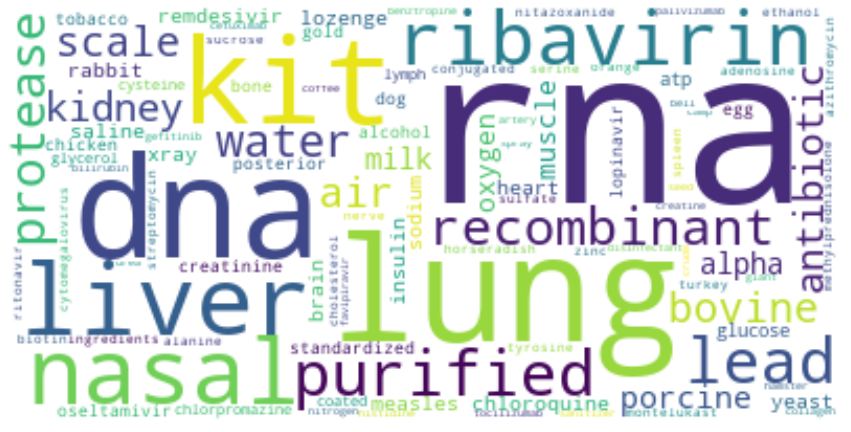

In [ ]:
# Let's create a word cloud. We will use this as header image for the Medium post.

# Create stopword list. Remove un wanted words.
stopwords_wc = ['mouse', 'palm', 'rabit', 'cattle', 'bulk']

# create a copy of match word dictionary
matched_only_dict_wc = matched_only_dict
# remove certain stopwords
for sw in stopwords_wc:
  matched_only_dict_wc.pop(sw, None)


# Generate a word cloud image
wordcloud = WordCloud(background_color="white", max_words=100).generate_from_frequencies(matched_only_dict)

# Display the generated image:
# the matplotlib way:
plt.figure(figsize=[15,10])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show();

## Focused analysis on 5 Drugs
- ribavirin
- choloroquine
- remdesivir
- oseltamivir
- lopinavir

In [ ]:
# fucntion to identify papers with mention of certain specific words
# creates a column for each search word with frequency of occurence as value
def identify_specific_papers(df, searchwords):
    """ Identifies papers that have mention of specific words.

    Input
    df - dataframe that contains matched words
    searchwords - a list of search words

    Output 
    df - dataframe with each search word as column with frequency of occurence for each paper id.
    """
    for idx, val in enumerate(searchwords):
      df[val] = list(map(lambda doc:[word for word in doc if word in val], df['match_words']))
      df[val] = list(map(lambda doc: len(doc), df[val]))
    
    return df

In [ ]:
# From the word frequency chart we identify certain drugs which are used in treating viral diseases
# We will focus our analysis on following drugs: 'remdesivir', 'ribavirin', 'chloroquine', 'oseltamivir', 'lopinavir'
searchwords = ['remdesivir', 'ribavirin', 'chloroquine', 'oseltamivir', 'lopinavir']
df_analysis = identify_specific_papers(df, searchwords)

In [ ]:
# check dataframe
df_analysis.head(5)

,paper_id,title,text,original_text,tokenized_text,contains_corona,stopwords_removed,match_words,match_words_freq,remdesivir,ribavirin,chloroquine,oseltamivir,lopinavir
2,005c43980edf3fcc2a4d12ee7ad630ddb651ce6e,Development of a smartphone-based rapid dual f...,avian influenza (ai) viruses are distinct from...,Avian influenza (AI) viruses are distinct from...,"[avian, influenza, ai, viruses, are, distinct,...","[cov, cov, cov]","[avian, influenza, ai, viruses, distinct, huma...","[gold, water, chicken, conjugated, mouse, coat...","{'gold': 1, 'water': 2, 'chicken': 2, 'conjuga...",0,0,0,0,0
32,0346cb9d0f5b07fe50d9a3cc0378a53f1a87708c,Statins May Decrease the Fatality Rate of Midd...,t he recent paper by totura and colleagues (1)...,T he recent paper by Totura and colleagues (1)...,"[t, he, recent, paper, by, totura, and, collea...",[cov],"[recent, paper, totura, colleagues, 1, reveale...","[ribavirin, lead, celecoxib, mesalamine, cyclo...","{'ribavirin': 1, 'lead': 1, 'celecoxib': 1, 'm...",0,1,0,0,0
50,0519d1d90353abf1d2a97d4fea15d24d48cf1fbd,Communicable Diseases and Outbreak Control REV...,infectious or communicable disease can be defi...,Infectious or communicable disease can be defi...,"[infectious, or, communicable, disease, can, b...",[cov],"[infectious, communicable, disease, defined, i...","[alcohol, air, measles, air, measles, mumps, w...","{'alcohol': 1, 'air': 2, 'measles': 10, 'mumps...",0,0,0,0,0
63,05e5a2bca07922fe0bd52185f4ccaae1b8b154f6,A phylogenetically distinct Middle East respir...,"since its first appearance in 2012, the middle...","Since its first appearance in 2012, the Middle...","[since, its, first, appearance, in, 2012, the,...",[cov],"[since, first, appearance, 2012, middle, east,...","[rna, milk, nasal, saline, sucrose, coated, na...","{'rna': 3, 'milk': 3, 'nasal': 9, 'saline': 1,...",0,0,0,0,0
80,08397cfd7c03fc339e42c1d4bb82449c54c7b111,What Has the COVID-19 Pandemic Taught Us so Fa...,"as of today, march 30, 2020, when this editori...","As of today, March 30, 2020, when this Editori...","[as, of, today, march, 30, 2020, when, this, e...",[covid],"[today, march, 30, 2020, editorial, written, s...","[liver, liver, liver, tobacco, lung, tobacco, ...","{'liver': 35, 'tobacco': 3, 'lung': 2, 'alanin...",0,0,0,1,1
88,097e78073b154805e74de8245008ee3f91c24af2,Nucleosides for the treatment of respiratory R...,respiratory viral infections are a global heal...,Respiratory viral infections are a global heal...,"[respiratory, viral, infections, are, a, globa...","[hcov, cov, hcov, cov, cov, cov, cov, cov, cov...","[respiratory, viral, infections, global, healt...","[rna, rna, rna, dna, rna, rna, nasal, nasal, l...","{'rna': 70, 'dna': 6, 'nasal': 4, 'lead': 2, '...",0,15,0,2,0
97,0a17c029515e527bfad8a67810ab82f4a3d6a299,The outbreak of COVID-19: An overview,"in late december 2019, an outbreak of a myster...","In late December 2019, an outbreak of a myster...","[in, late, december, 2019, an, outbreak, of, a...","[cov, cov]","[late, december, 2019, outbreak, mysterious, p...","[rna, palm, dog, palm, nasal, muscle, rna, xra...","{'rna': 2, 'palm': 2, 'dog': 1, 'nasal': 1, 'm...",2,2,0,0,2
103,0a449e173239afb38816257e1a53811b47bf13f4,,sion was diagnosed between 1 and 19 months aft...,sion was diagnosed between 1 and 19 months aft...,"[sion, was, diagnosed, between, 1, and, 19, mo...",[cov],"[sion, diagnosed, 1, 19, months, discharge, eb...","[scale, scale, scale, alpha, scale]","{'scale': 4, 'alpha': 1}",0,0,0,0,0
105,0a92a878b6603cb88dfc8c597e2a84407a0059ab,Position Paper,the following joint position statement represe...,The following Joint Position Statement represe...,"[the, following, joint, position, statement, r...",[covid],"[following, joint, position, statement, repres...","[scale, scale]",{'scale': 2},0,0,0,0,0
131,0dc475f4419836c2dc352073498f56ae982170a0,Age-related prevalence of common upper respira...,upper respiratory tract infections (uris) can ...,Upper respiratory tract infections (URIs) can ...,"

In [ ]:
# get title of paper for a given list of paper_ids
# reading through titles can help with understanding the overal content of the research paper
def get_paper_titles(paper_ids):
    '''
    INPUT
    paper_ids - a list of paper_ids
    OUTPUT
    paper - a list of titles associated with the paper_ids
    
    '''
    paper_lst = list(df[df['paper_id'].isin(paper_ids)]['title'])
   
    return list(paper_lst)

In [ ]:
# get articles for specific keyword
# Identify reasearch articles that contain mention of the certain drugs
def get_papers_count(df, keyword):
  '''
    INPUT
    df = dataframe with keywords as columns
    keyword - a list of key words you want to search paper ids against
    OUTPUT
    paper - a dictionary of paper ids associated with each keyword
  '''
  paper_ids = {}
  for val in keyword:
    # sort to get research papers with highest occurence of these words first
    df.sort_values(by=val, axis=0, ascending=False, inplace=True)
    paper_ids.update({val: list(df[df[val] != 0].paper_id.values)})
  return paper_ids

In [ ]:
# define drugs from word frequencies
keyword = ['remdesivir', 'ribavirin', 'chloroquine', 'oseltamivir', 'lopinavir']
drug_paper_ids = get_papers_count(df_analysis, keyword)

In [ ]:
# let's look title for each drug. Let's see from titles if we can identify any duplicates by reading the titles
paper_ids = drug_paper_ids['remdesivir']
# paper_ids = drug_paper_ids['ribavirin']
# paper_ids = drug_paper_ids['chloroquine']
# paper_ids = drug_paper_ids['oseltamivir']
# paper_ids = drug_paper_ids['lopinavir']

get_paper_titles(paper_ids)

['Middle East Respiratory Syndrome and Severe Acute Respiratory Syndrome: Current Therapeutic Options and Potential Targets for Novel Therapies',
 'R E V I E W A R T I C L E Open Forum Infectious Diseases Coronavirus Disease 2019 Treatment: A Review of Early and Emerging Options',
 'COVID-19 infection: Origin, transmission, and characteristics of human coronaviruses',
 "What Has the COVID-19 Pandemic Taught Us so Far? Addressing the Problem from a Hepatologist's Perspective",
 'MERS-coronavirus: From discovery to intervention',
 'Nucleosides for the treatment of respiratory RNA virus infections',
 'Nucleosides for the treatment of respiratory RNA virus infections Introduction to respiratory infections caused by RNA viruses',
 'Characteristics and Mechanism of Liver Injury in 2019 Coronavirus Disease',
 'Respiratory Viral Infections after Hematopoietic Stem Cell Transplantation in Children',
 'New Respiratory Viruses and the Elderly',
 'IgY antibodies for the immunoprophylaxis and thera

In [ ]:
# run the above function for each drug and see if you can spot duplicates.
# manually remove duplicates by looking at titles for each drug.
# 1. choloroquine: remove last paper id since it's duplicative.
drug_paper_ids['chloroquine'].remove('496c9b4e424bc052895fd0c9446e14f565dcaae5')
# 2. ribavirin
drug_paper_ids['ribavirin'].remove('097e78073b154805e74de8245008ee3f91c24af2')
# 3. oseltamivir
drug_paper_ids['oseltamivir'].remove('097e78073b154805e74de8245008ee3f91c24af2')

In [ ]:
# Plot number of articles for each drug
drug_paper_ids_count = {}
for key, value in drug_paper_ids.items():
  drug_paper_ids_count.update({key: len(value)})

drug_paper_ids_df = pd.DataFrame.from_dict(drug_paper_ids_count, orient='index')
drug_paper_ids_df.rename(columns={0: 'count'}, inplace=True)
drug_paper_ids_df.sort_values('count', ascending=False, inplace=True)

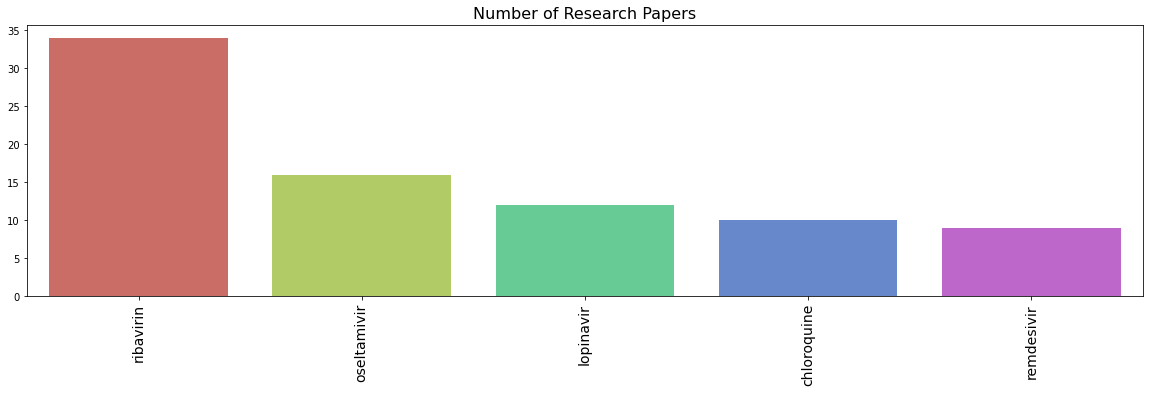

In [ ]:
ax_drugs = word_frequency_barplot(drug_paper_ids_df, 5)
ax_drugs.set_title("Number of Research Papers", fontsize=16);

It seems ‘Ribavirin’ has the highest incidence in the corpus of research papers but does that mean there will be high demand for this drug?
Let's look at the sentences from within the research papers that contain mention of 'Ribavirin'.

### Question 2
Can we ascertain demand for certain drugs by analyzing these research papers?

**Analysis steps:** Create a list of drugs with their non proprietary names and identify each occurrence with frequency of occurrence.

**Outcome:** 5 drugs stand out: ribavirin, chloroquine, remdesivir, oseltamivir, lopinavir. Given so much interest in these drugs, you can assume high demand for these drugs and their underlying salts.


---





### Ribavirin analysis

In [ ]:
# get sentences
def get_sentences(df, ):
    """ Split text into sentences.
    All mutations are done on the dataframe itself. So this function returns
    nothing.
    """
    df['text'] = df.text.str.lower()
    df['document_sentences'] = df.text.str.split('.')  # split texts into individual sentences

In [ ]:
def get_relevant_sentences(df, paper_id, searchword):
  """ function to print specific sentences from a particular research paper that contains the search word provided.

  Input
  df - dataframe with match words as columns
  paper_id - paper_id of research paper that I want to see sentences for
  searchword - drug name
  """
  text = list(df.original_text[df['paper_id'] == paper_id].str.split('.'))
  text = list(chain(*text))

  # get list ids with occurence of search word
  text_idx =[]
  for idx, val in enumerate(text):
    if searchword in val:
      text_idx.append(idx)
      print(idx)
      print(val)


In [ ]:
# get all research paper_ids for drug 'ribavirin'
drug_paper_ids['ribavirin']

['84c860b82c331e08dc0269ef951de3b53dee41d8',
 'f9a3b2b8a17beb5d81c2111277d9645dc137dd32',
 'PMC5890544',
 'PMC6074560',
 '9e91991355bc76a376b379387983a5ac08f179ab',
 '248ab12f092b53d6482d828b1ec1b7a9d6a5e385',
 '372c5fab99bbe7f7862304f94bfaebd3c02f1e1c',
 'PMC5454172',
 'PMC5532318',
 '496c9b4e424bc052895fd0c9446e14f565dcaae5',
 'PMC4611038',
 'PMC4716277',
 'c530c756cc04b3476f21b4edd5a6aa5f3d704745',
 '0a17c029515e527bfad8a67810ab82f4a3d6a299',
 '1fe9d44383ae2debf062555ea05a816dd3848a91',
 '7d23656771268d325fc276045ff002b7d0184e7b',
 'de511623eb1661bfa9c81a2749c786d9cbc178ba',
 'e6d882be4961d1bdd7507b4a29d86b650de0895d',
 'f5b032ddcc2c69fa564eec3ac027060064d7b255',
 'PMC6252006',
 'bef1a1f01d8a818aa005fae2e3b52dc369a79aab',
 '3230a822ceaf337c5137d32e1505878910621991',
 'PMC7140187',
 'PMC4720805',
 '4edda548e89522b4df20e723e29c63f309857b10',
 'PMC4155143',
 'PMC5840604',
 'PMC3522051',
 'PMC4447251',
 '5d58ccdb0252429f7c74ece67b505a2afd7e08c9',
 '5daf138e225910628fdfea4f94b36a077392ef

In [ ]:
# What could be the reason for highest number of articles for drug 'Ribavirin'.
# Let's look at some of the sentences within the research paper that contains mention of 'Ribavirin'
# Run the below function for multiple paper_ids from the list above.
get_relevant_sentences(df_analysis, 'PMC5454172', 'ribavirin')

56
 Other broad spectrum antivirals, such as ribavirin, mycophenolic acid and cyclosporine-A, also have antiviral activity against MERS-CoV in-vitro
57
 Combinations of ribavirin and IFNα may have a synergistic effect as shown by in-vitro and in vivo studies in rhesus macaques [19], [20]
63
 The limited effective therapeutic window of opportunity of type I IFN might explain why a cocktail regimen of ribavirin and IFNα did not improve the overall survival rates seen in human MERS cases, despite these promising in-vitro and in-vivo results [18], [19], [20], [23], [24]


**Ribavirin observations:**

-  These two patients both received pegylated interferon alpha-2a, ribavirin, and lopinavir/ritonavir to treat MERS-CoV
- Similarly, the exoribonuclease activity of MERS-CoV and SARS-CoV could possibly counteract inhibitory activity of ribavirin
- Ribavirin weakly inhibits MERS-CoV in vitro, and conflicting data has been reported for the activity of ribavirin against SARS-CoV
- There was a delay in the diagnosis, and the initiation of treatment with ribavirin and IFN-α2b indicated the possibility that the early initiation of therapy might be helpful in patients with MERS CoV infection
47
- This small case series suggests a possible role of ribavirin and IFN-α2b in the treatment of human MERS CoV infection, if started early in the illness
- Other broad spectrum antivirals, such as ribavirin, mycophenolic acid and cyclosporine-A, also have antiviral activity against MERS-CoV in-vitro 57

A quick look at only those sentences that contain ‘ribavirin’, I could identify high correlation with Mers Cov infection.

So the reason for highest incidence of ‘ribavirin’ could be because it was used in treatment for mers patients.

In [ ]:
# I see a high incidence of Mers-Cov in the research papers.
# Let's create a subset of our original dataframe with only the articles containing 'Ribavirin'.
# Use the below funtion to highlight high incidence of 'Mers' in 'Ribavirin' research papers.

def get_search_word(df, searchwords, drugid):
  # subset dataframe for only those papers that have mention of drugid
  df = df[df['paper_id'].isin(drug_paper_ids[drugid])]
  

  # search for the text
  df[searchwords] = list(map(lambda doc: [word for word in doc if word in searchwords], df['tokenized_text']))
  # get the count
  df[searchwords] = list(map(lambda doc: len(doc), df[searchwords]))

  df.sort_values(by=[drugid,searchwords], axis=0, ascending=False, inplace=True)

  return df[['paper_id', drugid, searchwords]]

In [ ]:
df_analysis_ribavirin = get_search_word(df_analysis, 'mers', 'ribavirin')

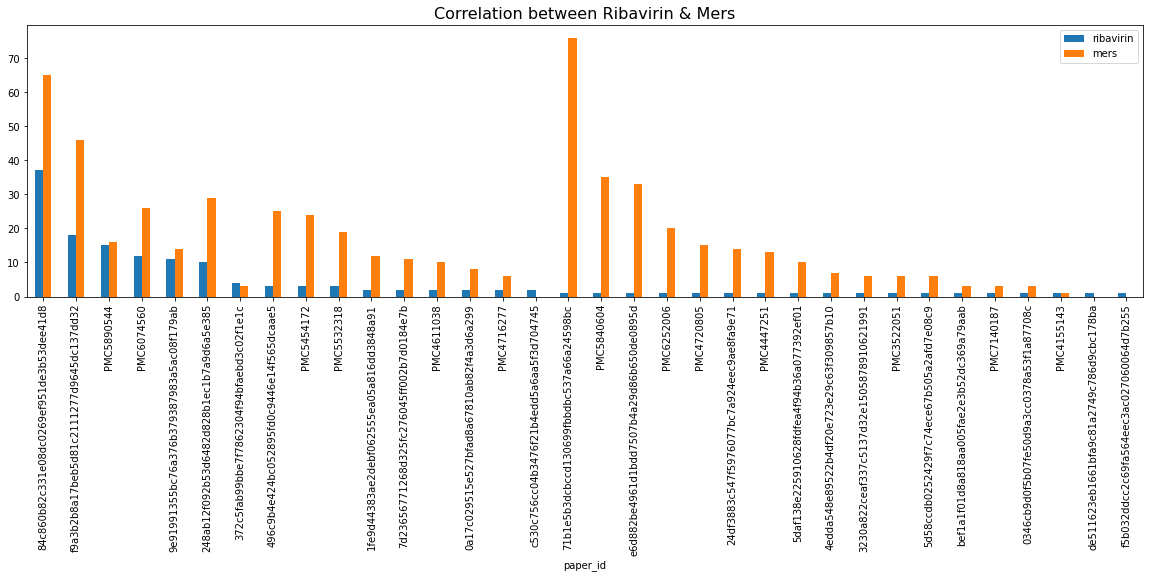

In [ ]:
# Plot count of occurrence of 'Mers' in research papers containing 'Ribavirin'.
fig, ax = plt.subplots(1,1,figsize=(20,5))
df_analysis_ribavirin.plot(x='paper_id', y=['ribavirin', 'mers'], ax = ax, kind="bar")
ax.set_title("Correlation between Ribavirin & Mers", fontsize=16);
plt.show()

The above plot helps us establish the fact that while ‘ribavirin’ has the highest mention but it’s less related to covid-19 and hence not a good predictor of demand.

---


### Oseltamivir analysis

In [ ]:
# Now let's look at oseltamivir
drug_paper_ids['oseltamivir']

['248ab12f092b53d6482d828b1ec1b7a9d6a5e385',
 'PMC3805478',
 'PMC5890544',
 'f394c17bf245ebbff60558cc2e70e53556aaa843',
 '372c5fab99bbe7f7862304f94bfaebd3c02f1e1c',
 '08397cfd7c03fc339e42c1d4bb82449c54c7b111',
 'f5b032ddcc2c69fa564eec3ac027060064d7b255',
 'fc1f4b62e7c63ec2a3536401ce6aea880dca8512',
 '3230a822ceaf337c5137d32e1505878910621991',
 'f9a3b2b8a17beb5d81c2111277d9645dc137dd32',
 '2c0813f50214197ccbeae857bb05217ade8aae82',
 'PMC3522051',
 '496c9b4e424bc052895fd0c9446e14f565dcaae5',
 'PMC5454172',
 '84c860b82c331e08dc0269ef951de3b53dee41d8',
 '5daf138e225910628fdfea4f94b36a077392ef01']

In [ ]:
# let's look at sentences for each paper id.
get_relevant_sentences(df_analysis, '496c9b4e424bc052895fd0c9446e14f565dcaae5', 'oseltamivir')

124
 Post-exposure prophylaxis using oseltamivir was shown to be effective in reducing influenza transmission during the 2009 H1N1 influenza outbreak in Singapore military camps [62] 


**Oseltamivir observations:** mostly negative effect on covid-19

- 'therefore, given the critical need for these agents in the management of influenza and concern for drug shortages with oseltamivir, these agents should be avoided in patients with covid-19 once influenza has been ruled out'
- 'although treated with mechanical ventilation, broad spectrum antibiotics, oseltamivir, immunological therapy, and fluid resuscitation, she died of multi-organ failure and cardiac arrest on 24 april'
- 'the approved drugs include zanamivir, oseltamivir, peramivir, and favipiravir (japan only) for influenza virus and palivizumab for rsv, all of which have limitations that prevent their widespread use in a therapeutic setting'
- ' the use of antipyretics, such as paracetamol, and certain antivirals, like oseltamivir, lopinavir and ritonavir, for the management of covid-19 has been widely reported to be associated with the development of liver injury'


### Lopinavir analysis

In [ ]:
# Now let's look at lopinavir
drug_paper_ids['lopinavir']

['84c860b82c331e08dc0269ef951de3b53dee41d8',
 '248ab12f092b53d6482d828b1ec1b7a9d6a5e385',
 '1fe9d44383ae2debf062555ea05a816dd3848a91',
 '0a17c029515e527bfad8a67810ab82f4a3d6a299',
 'e6d2c030bb4bb71cae43fd29624e70872b1662a4',
 'PMC4720805',
 'PMC7097833',
 'de511623eb1661bfa9c81a2749c786d9cbc178ba',
 'PMC6252006',
 '5daf138e225910628fdfea4f94b36a077392ef01',
 '4edda548e89522b4df20e723e29c63f309857b10',
 '08397cfd7c03fc339e42c1d4bb82449c54c7b111']

In [ ]:
# let's look at sentences for each paper id.
get_relevant_sentences(df_analysis, '84c860b82c331e08dc0269ef951de3b53dee41d8', 'lopinavir')

38
4% [27] IFN-alfacon-1 ± corticosteroids ± antibioticsIncreased oxygen saturation Increased clearance of lung abnormalities Slight increase in creatinine kinase concentrations [29, 247] Fluoroquinolone (IV) Azithromycin (IV)± corticosteroids ± Immunoglobulins ± thymic peptides/ proteinsNo increased positive outcome [248] Quinolone (IV)± IFN-a ± corticosteroidsNo increased positive outcome [248] Levofloxacin Azithromycin ± IFN-a ± corticosteroidsIncreased clearance of lung abnormalities [248] IFN interferon, IM intramuscular, IV intravenous, SARS severe acute respiratory syndrome Additional studies tested the efficacy of ribavirin in conjunction with lopinavir, an anti-retroviral agent
41
 In addition, 41 of the confirmed SARS patients were also treated with a combination of lopinavir (400 mg) and ritonavir (100 mg)
53
 In an additional case study, a 69-year-old Greek patient who contracted MERS in Jeddah was treated with oral lopinavir/ritonavir (400/100 mg twice daily), pegylated IF

**Lopinavir observations:** mostly negative observations.

- 'the use of antipyretics, such as paracetamol, and certain antivirals, like oseltamivir, lopinavir and ritonavir, for the management of covid-19 has been widely reported to be associated with the development of liver injury'
- 'cyclosporin a, and mycophenolic acid, chloroquine, chlorpromazine, loperamide, and lopinavir inhibit mers-cov growth in vitro but their activity on the human is yet to be established'
- 'while there is no proven effective antiviral therapy against sars-cov (33), several molecules have in vitro antiviral activity, including ribavirin, lopinavir, and type i ifn, but their benefits for patients are unclear'


### Chloroquine analysis

In [ ]:
# Now let's look at chloroquine
drug_paper_ids['chloroquine']

['248ab12f092b53d6482d828b1ec1b7a9d6a5e385',
 'PMC7097833',
 '29d15895b6f3c6472f3bab820d6a99feefae60df',
 'de511623eb1661bfa9c81a2749c786d9cbc178ba',
 'PMC5454172',
 '84c860b82c331e08dc0269ef951de3b53dee41d8',
 'PMC7117643',
 'PMC6252006',
 'c530c756cc04b3476f21b4edd5a6aa5f3d704745',
 '5daf138e225910628fdfea4f94b36a077392ef01']

In [ ]:
# let's look at sentences for each paper id.
get_relevant_sentences(df_analysis, '248ab12f092b53d6482d828b1ec1b7a9d6a5e385', 'chloroquine')

63
 In early February, Wang et al [3] demonstrated potent in vitro activity of chloroquine against SARS-CoV-2 with an EC 50 at 48 hours of 1
65
 These data were consistent with previous data for chloroquine's inhibitory activity against SARS-CoV-1 and MERS-CoV in various cell lines, where EC 50 values of 1-8
68
 These findings have supported the clinical use of chloroquine, at a dose of 500 mg by mouth twice daily, in numerous clinical trials in China during this outbreak
70
 Per Gao et al [16] , "thus far, results from more than 100 patients have demonstrated that chloroquine phosphate is superior to the control treatment in inhibiting the exacerbation of pneumonia, improving lung imaging findings, promoting a virus-negative conversion, and shortening the disease course according to the news briefing
71
 Severe adverse reactions to chloroquine phosphate were not noted in the aforementioned patients
72
 "Although this development has been encouraging, supply issues in the United States

**Chloroquine observations:**

Negative observations:
- 'the data from sars-cov-1 are encouraging, but this must be weighed against the inferior performance in mouse models against mers-cov, the less potent *in vitro* activity compared with remdesivir and chloroquine for sars-cov-1, and limited data suggesting no advantage over standard care for sars-cov-2'

Positive observations:
- 'it acts by inhibiting viral polymerasea recent study exploring *in-vitro* activity of remdesivir and chloroquine has demonstrated efficacy of the drugs in inhibiting replication of sars-cov2'
- 'chloroquine is another promising drug, an *in vitro* study on the timeof-addition assay in vero e6 cells demonstrated that chloroquine functioned at both entry and at post-entry stages of covid-19'
- 'moreover, chloroquine and remdesivir were shown to effectively inhibit sars-cov-2 infection *in vitro*'
- 'two research groups reported that both chloroquine and chlorpromazine have potential therapeutic antiviral activity'
- 'the antimalarial agents, chloroquine (cq), amodiaquine, and mefloquine have activity against sars-cov and mers-cov *in vitro*, importantly, hydroxychloroquine, a cq derivate, may provide an alternative due to lower toxicity and similar pharmacology profile'
- 'other phase iii agents being evaluated in combination therapy for viral pneumonia interestingly include the antimalarial hydroxychloroquine, based on promising *in vitro* data (clinicaltrials)' 
- 'chloroquine, in addition to its immunomodulating properties, has been shown to have antiviral activity at entry and post-entry stages of the sars-cov-2 infection'
- 'also, chloroquine, interferon and protease inhibitors, such as ritonavir, lopinavir/ritonavir, reported being effective in inhibiting the virus invitro'
- 'remdesivir only and in combination with chloroquine or interferon beta significantly blocked the sars-cov-2 replication and patients were declared as clinically recovered'
- thus far, results from more than 100 patients have demonstrated that chloroquine phosphate is superior to the control treatment in inhibiting the exacerbation of pneumonia, improving lung imaging findings, promoting a virus-negative conversion, and shortening the disease course according to the news briefing
- severe adverse reactions to chloroquine phosphate were not noted in the aforementioned patients
- 'cyclosporin a, and mycophenolic acid, chloroquine, chlorpromazine, loperamide, and lopinavir inhibit mers-cov growth *in vitro* but their activity on the human is yet to be established'

Supply chain considerations:

- "although this development has been encouraging, supply issues in the united states and cardiovascular toxicity concerns limit the use of chloroquine
- as an alternative, hydroxychloroquine, a compound that differs from chloroquine only by a single hydroxyl group, has garnered interest
- hydroxychloroquine is perceived as having better tolerability than chloroquine, which has led to long-term usage in rheumatological disorders
- historically, very limited data were published assessing the activity of hydroxychloroquine against coronaviruses

---
With so many positive results, no wonder lot of people were excited about this drug! But notice something interesting? Count the word ‘in-vitro’ in these sentences and you will realize that all these results were from studies in lab and not from clinically treating patients.

Also, from supply chain perspective, one thing to note is that Hydroxychloroquine is alternative that can be used.




### Remdesivir observations:

In [ ]:
# Now let's look at remdesivir
drug_paper_ids['remdesivir']

['248ab12f092b53d6482d828b1ec1b7a9d6a5e385',
 'PMC7097833',
 '5daf138e225910628fdfea4f94b36a077392ef01',
 'de511623eb1661bfa9c81a2749c786d9cbc178ba',
 'c530c756cc04b3476f21b4edd5a6aa5f3d704745',
 '29d15895b6f3c6472f3bab820d6a99feefae60df',
 '0a17c029515e527bfad8a67810ab82f4a3d6a299',
 'PMC7117643',
 'e6d2c030bb4bb71cae43fd29624e70872b1662a4']

In [ ]:
# let's look at sentences for each paper id.
get_relevant_sentences(df_analysis, '248ab12f092b53d6482d828b1ec1b7a9d6a5e385', 'remdesivir')

16
 In its active triphosphate nucleoside form, remdesivir binds to ribonucleic acid (RNA)-dependent RNA polymerase and acts as an RNA-chain terminator
22
 Accordingly, Sheahan et al [6] demonstrated a wide therapeutic index for remdesivir in a human airway epithelial cell model
25
The therapeutic efficacy of remdesivir was first described in an animal model against Ebola among infected rhesus monkeys in which once-daily dosing resulted in suppression of viral replication and protection from lethal disease [9] 
26
 However, in a human study, remdesivir-treated patients with Ebola experienced a 28-day mortality rate of 53% in a randomized controlled trial of 4 experimental therapies conducted in response to the Democratic Republic of Congo outbreak of 2018, resulting in early termination of this study arm [10] 
31
 Against MERS-CoV, Sheahan et al [5] evaluated the therapeutic efficacy of remdesivir among infected mice and found treatment significantly reduced virus lung titers, weight l

**Remdesivir observations:**

Positive:
- 'emerging clinical evidence and available in vitro data suggest remdesivir is a promising agent for the treatment of covid-19'
- 'recent case report described the use of remdesivir, requested for compassionate use, in the first patients with covid-19 in the united states. two ongoing clinical randomized clinical trials in china are evaluating remdesivir for moderate and sever covid-19 infections'
- 'at the phase iii level, remdesivir, a viral rna-dependent rna polymerase inhibitor, is under investigation for mild and moderate sars-cov-2'
- 'moreover, chloroquine and remdesivir were shown to effectively inhibit sars-cov-2 infection in vitro'
- 'initially, interferons-a nebulization, broad-spectrum antibiotics, and anti-viral drugs were used to reduce the viral load, however, only remdesivir has shown promising impact against the virus. remdesivir only and in combination with chloroquine or interferon beta significantly blocked the sars-cov-2 replication and patients were declared as clinically recovered'
- 'in a case report on the first case of 2019-ncov in the united states administering remdesivir for compassionate use on day 11 after illness resulted in decreasing viral loads in nasopharyngeal and oropharyngeal samples and the patient's clinical condition improved'

**Other observations:**

Recommended dosage:
- 'the recommended dosage for sarscov- 2 infection is chloroquine 500 mg bid or hydroxychloroquine 200 mg bid for 10 days in combination with another antiviral agent (lopinavir/ritonavir or remdesivir)'

Supply chain, demand:
- 'in the light of the possible shortage of lopinavir/ritonavir stocks due to the increasing prescriptions, we suggest the possible use of darunavir/ritonavir at the dosage of 600 mg ever 12 hours in replacement of lopinavir/ritonavir considering the similar mechanism of action and the optimal safety profile'


### Question 3
Is it possible to identify efficacy of certain drugs i.e. can we identify which drugs have been most effective in treating patients?

**Analysis steps:** Applied a combination of keyword search and manual reading of sentences within the research paper. By reading sentences you can classify them as Positive or Negative from an efficacy of treatment perspective.

**Outcome:** Out of 5 drugs you can clearly identify 2 drugs remdesivir and chloroquine with examples of positive effect and future potential.


---

